In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

# determine the file names of associated player data
main_directory = os.path.normpath(os.getcwd() + os.sep + os.pardir)
data_directory = os.path.join(main_directory, 'data')
file_names = [f for f in os.listdir(data_directory) if os.path.isfile(os.path.join(data_directory, f))]
print(file_names)

['00-01 player stats per game.csv', '00-01 player stats.csv', '01-02 player stats per game.csv', '01-02 player stats.csv', '02-03 player stats per game.csv', '02-03 player stats.csv', '03-04 player stats per game.csv', '03-04 player stats.csv', '04-05 player stats per game.csv', '04-05 player stats.csv', '05-06 player stats per game.csv', '05-06 player stats.csv', '06-07 player stats per game.csv', '06-07 player stats.csv', '07-08 player stats per game.csv', '07-08 player stats.csv', '08-09 player stats per game.csv', '08-09 player stats.csv', '09-10 player stats per game.csv', '09-10 player stats.csv', '10-11 player stats per game.csv', '10-11 player stats.csv', '11-12 player stats per game.csv', '11-12 player stats.csv', '12-13 player stats per game.csv', '12-13 player stats.csv', '13-14 player stats per game.csv', '13-14 player stats.csv', '14-15 player stats per game.csv', '14-15 player stats.csv', '15-16 player stats per game.csv', '15-16 player stats.csv', '16-17 player stats per

In [2]:
# seperates out data associated with total player stats and player stats per game
player_stat_total_csv = [file for file in file_names if 'stats.csv' in file]
player_stat_pergame_csv = [file for file in file_names if 'game.csv' in file]
player_stat_total_csv = player_stat_total_csv[:-2]
print(player_stat_total_csv)
print(player_stat_pergame_csv)

['00-01 player stats.csv', '01-02 player stats.csv', '02-03 player stats.csv', '03-04 player stats.csv', '04-05 player stats.csv', '05-06 player stats.csv', '06-07 player stats.csv', '07-08 player stats.csv', '08-09 player stats.csv', '09-10 player stats.csv', '10-11 player stats.csv', '11-12 player stats.csv', '12-13 player stats.csv', '13-14 player stats.csv', '14-15 player stats.csv', '15-16 player stats.csv', '16-17 player stats.csv', '17-18 player stats.csv', '18-19 player stats.csv', '19-20 player stats.csv', '20-21 player stats.csv', '21-22 player stats.csv', '22-23 player stats.csv']
['00-01 player stats per game.csv', '01-02 player stats per game.csv', '02-03 player stats per game.csv', '03-04 player stats per game.csv', '04-05 player stats per game.csv', '05-06 player stats per game.csv', '06-07 player stats per game.csv', '07-08 player stats per game.csv', '08-09 player stats per game.csv', '09-10 player stats per game.csv', '10-11 player stats per game.csv', '11-12 player s

In [3]:
# determine the name of the headers associated with the data in the csv files (we will do this to ensure that all files are consistent)
directory = os.path.join(data_directory, player_stat_total_csv[0])
# read the 2000 total player stats into a data frame
df = pd.read_csv(directory)
# determine the headers of the data frame
headers = df.columns
print(headers)

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Player-additional'],
      dtype='object')


In [4]:
# open all total player stat csv and combine them into one large data frame
# define player_stat_df as a dataframe
player_stat_df = pd.DataFrame()
MVP_player_data = pd.read_csv('MVP player stats.csv')
defensive_player_data = pd.read_csv('Defensive Player of the Year player stats.csv')
i = 23

# for all files in the player_stat_total_csv vector open them and add them to the combined vector
for filename in player_stat_total_csv:
    # add counter variable so MVP and Denfensive player dataframes can be indexed
    i = i - 1
    directory = os.path.join(data_directory,filename)
    # extract data from one year
    df = pd.read_csv(directory)
    # extract the year the player data is from
    season = (filename[0:2] + filename[3:5])
    # add the year to the data frame
    df['Year'] = season
    # remove the asterisk from the end of players names
    df['Player'] = df['Player'].str.replace('*', '')
    # current MVP and Defensive player winners
    current_MVP = MVP_player_data['Unnamed: 2'][i]
    current_defense = defensive_player_data['Unnamed: 2'][i]
    # adds information about winners of MVP and Defense award to dataframe
    df['MVP Award'] = df['Player'].apply(lambda x: 1 if x == current_MVP else 0)
    df['Defensive Award'] = df['Player'].apply(lambda x: 1 if x == current_defense else 0)
    # if the data has the correct number of headers it is added to the new dataframe
    if len(df.columns) == (len(headers) + 3):
        player_stat_df = pd.concat([player_stat_df, df])
    else:
        print('this file did not match the header ',filename)

    
player_stat_df = player_stat_df.reset_index(drop=True)
display(player_stat_df.head())

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Player-additional,Year,MVP Award,Defensive Award
0,1,Mahmoud Abdul-Rauf,PG,31,VAN,41,0,486,120,246,...,76,9,1,26,50,266,abdulma02,0001,0,0
1,2,Tariq Abdul-Wahad,SG,26,DEN,29,12,420,43,111,...,22,14,13,34,54,111,abdulta01,0001,0,0
2,3,Shareef Abdur-Rahim,SF,24,VAN,81,81,3241,604,1280,...,250,90,77,231,238,1663,abdursh01,0001,0,0
3,4,Cory Alexander,PG,27,ORL,26,0,227,18,56,...,36,16,0,25,29,52,alexaco01,0001,0,0
4,5,Courtney Alexander,PG,23,TOT,65,24,1382,239,573,...,62,45,5,75,139,618,alexaco02,0001,0,0


In [5]:
# repeat the last two cell aboves to create a dataframe containing all player stat per game data
directory = os.path.join(data_directory, player_stat_pergame_csv[0])
df = pd.read_csv(directory)
headers = df.columns
print(headers)

Index(['Rk', 'Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%',
       '3P', '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS',
       'Player-additional'],
      dtype='object')


In [6]:
player_stat_game_df = pd.DataFrame()
i = 23

# for all files in the player_stat_pergame_csv vector open them and add them to the combined dataframe
for filename in player_stat_pergame_csv:
    directory = os.path.join(data_directory,filename)
    df = pd.read_csv(directory)
    # add counter variable so MVP and Denfensive player dataframes can be indexed
    i = i - 1
    directory = os.path.join(data_directory,filename)
    # extract data from one year
    df = pd.read_csv(directory)
    # extract the year the player data is from
    season = (filename[0:2] + filename[3:5])
    # add the year to the data frame
    df['Year'] = season
    # remove the asterisk from the end of players names
    df['Player'] = df['Player'].str.replace('*', '')
    # current MVP and Defensive player winners
    current_MVP = MVP_player_data['Unnamed: 2'][i]
    current_defense = defensive_player_data['Unnamed: 2'][i]
    # adds information about winners of MVP and Defense award to dataframe
    df['MVP Award'] = df['Player'].apply(lambda x: 1 if x == current_MVP else 0)
    df['Defensive Award'] = df['Player'].apply(lambda x: 1 if x == current_defense else 0)
    # if the data has the correct number of headers it is added to the new dataframe
    if len(df.columns) == (len(headers) + 3):
        player_stat_game_df = pd.concat([player_stat_game_df, df])
    else:
        print('this file did not match the header ',filename)
    
player_stat_game_df = player_stat_game_df.reset_index(drop=True)
display(player_stat_game_df.head())

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,AST,STL,BLK,TOV,PF,PTS,Player-additional,Year,MVP Award,Defensive Award
0,1,Mahmoud Abdul-Rauf,PG,31,VAN,41,0,11.9,2.9,6.0,...,1.9,0.2,0.0,0.6,1.2,6.5,abdulma02,0001,0,0
1,2,Tariq Abdul-Wahad,SG,26,DEN,29,12,14.5,1.5,3.8,...,0.8,0.5,0.4,1.2,1.9,3.8,abdulta01,0001,0,0
2,3,Shareef Abdur-Rahim,SF,24,VAN,81,81,40.0,7.5,15.8,...,3.1,1.1,1.0,2.9,2.9,20.5,abdursh01,0001,0,0
3,4,Cory Alexander,PG,27,ORL,26,0,8.7,0.7,2.2,...,1.4,0.6,0.0,1.0,1.1,2.0,alexaco01,0001,0,0
4,5,Courtney Alexander,PG,23,TOT,65,24,21.3,3.7,8.8,...,1.0,0.7,0.1,1.2,2.1,9.5,alexaco02,0001,0,0


In [7]:
# save new dataframes into a csv
player_stat_game_df.to_csv('player_stat_per_game.csv',header=True,index=False)
player_stat_df.to_csv('player_stat.csv',header=True,index=False)

In [8]:
# clean total player data
# create more valuable column titles
name_map = {'Rk':'Rank','Pos':'Position','Tm':'Team','G':'Games','GS':'Games Started','MP':'Total Minutes Played',
             'FG':'Total Field Goals','FGA':'Total Field Goal Attempts','FG%':'Field Goal Percentage','3P':'Total 3 Point Field Goals',
             '3PA':'Total 3 Point Field Goal Attempts', '3P%':'3 Point Field Goal Percentage','2P':'Total 2 Point Field Goals', '2PA':'Total 2 Point Field Goal Attempts',
             '2P%':'2 Point Field Goal Percentage', 'eFG%':'Effective Field Goal Percentage', 'FT':'Total Free Throws',
             'FTA':'Total Free Throw Attempts','FT%':'Free Throw Percentage','ORB':'Total Offensive Rebounds','DRB':'Total Defensive Rebounds',
             'TRB':'Total Rebounds','AST':'Total Assists','STL':'Total Steals','BLK':'Total Blocks','TOV':'Total Turn Overs',
             'PF':'Total Personal Fouls','PTS':'Total Points'}
player_stat_df = player_stat_df.rename(columns=name_map)

# drop unecessary column
player_stat_df = player_stat_df.drop(columns = ['Player-additional'])

In [9]:
# determine the number of NaN values in each column
display(player_stat_df.isnull().sum())

# visualize where the NaN values are
pd.set_option('display.max_columns', None)
display(player_stat_df.head(20))

# many NaN values are from players with 0 made shots, therefore the make percentage is NaN
# the following code will replace the appropriate percentages with 0 in the cases of NaN
result = player_stat_df['Total Field Goals'] / player_stat_df['Total Field Goal Attempts']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_df['Field Goal Percentage'] = result

result = player_stat_df['Total 3 Point Field Goals'] / player_stat_df['Total 3 Point Field Goal Attempts']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_df['3 Point Field Goal Percentage'] = result

result = player_stat_df['Total 2 Point Field Goals'] / player_stat_df['Total 2 Point Field Goal Attempts']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_df['2 Point Field Goal Percentage'] = result

result = player_stat_df['Total Free Throws'] / player_stat_df['Total Free Throw Attempts']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_df['Free Throw Percentage'] = result

result = (player_stat_df['Total Field Goals'] + 0.5 *  player_stat_df['Total 3 Point Field Goals'])/ player_stat_df['Total Field Goal Attempts']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_df['Effective Field Goal Percentage'] = result

# check to make sure that NaN values have been removed
display(player_stat_df.isnull().sum())

Rank                                    0
Player                                  0
Position                                0
Age                                     0
Team                                    0
Games                                   0
Games Started                           0
Total Minutes Played                    0
Total Field Goals                       0
Total Field Goal Attempts               0
Field Goal Percentage                  83
Total 3 Point Field Goals               0
Total 3 Point Field Goal Attempts       0
3 Point Field Goal Percentage        1930
Total 2 Point Field Goals               0
Total 2 Point Field Goal Attempts       0
2 Point Field Goal Percentage         152
Effective Field Goal Percentage        83
Total Free Throws                       0
Total Free Throw Attempts               0
Free Throw Percentage                 716
Total Offensive Rebounds                0
Total Defensive Rebounds                0
Total Rebounds                    

,Rank,Player,Position,Age,Team,Games,Games Started,Total Minutes Played,Total Field Goals,Total Field Goal Attempts,Field Goal Percentage,Total 3 Point Field Goals,Total 3 Point Field Goal Attempts,3 Point Field Goal Percentage,Total 2 Point Field Goals,Total 2 Point Field Goal Attempts,2 Point Field Goal Percentage,Effective Field Goal Percentage,Total Free Throws,Total Free Throw Attempts,Free Throw Percentage,Total Offensive Rebounds,Total Defensive Rebounds,Total Rebounds,Total Assists,Total Steals,Total Blocks,Total Turn Overs,Total Personal Fouls,Total Points,Year,MVP Award,Defensive Award
0,1,Mahmoud Abdul-Rauf,PG,31,VAN,41,0,486,120,246,0.488,4,14,0.286,116,232,0.500,0.496,22,29,0.759,5,20,25,76,9,1,26,50,266,0001,0,0
1,2,Tariq Abdul-Wahad,SG,26,DEN,29,12,420,43,111,0.387,4,10,0.400,39,101,0.386,0.405,21,36,0.583,14,45,59,22,14,13,34,54,111,0001,0,0
2,3,Shareef Abdur-Rahim,SF,24,VAN,81,81,3241,604,1280,0.472,12,64,0.188,592,1216,0.487,0.477,443,531,0.834,175,560,735,250,90,77,231,238,1663,0001,0,0
3,4,Cory Alexander,PG,27,ORL,26,0,227,18,56,0.321,4,16,0.250,14,40,0.350,0.357,12,18,0.667,0,25,25,36,16,0,25,29,52,0001,0,0
4,5,Courtney Alexander,PG,23,TOT,65,24,1382,239,573,0.417,17,46,0.370,222,527,0.421,0.432,123,150,0.820,42,101,143,62,45,5,75,139,618,0001,0,0
5,5,Courtney Alexander,PG,23,DAL,38,6,472,62,178,0.348,3,10,0.300,59,168,0.351,0.357,33,45,0.733,20,43,63,21,16,3,21,76,160,0001,0,0
6,5,Courtney Alexander,PG,23,WAS,27,18,910,177,395,0.448,14,36,0.389,163,359,0.454,0.466,90,105,0.857,22,58,80,41,29,2,54,63,458,0001,0,0
7,6,Ray Allen,SG,25,MIL,82,82,3129,628,1309,0.480,202,467,0.433,426,842,0.506,0.557,348,392,0.888,101,327,428,374,124,20,204,192,1806,0001,0,0
8,7,Rafer Alston,PG,24,MIL,37,2,288,30,84,0.357,8,30,0.267,22,54,0.407,0.405,9,13,0.692,4,27,31,68,13,0,20,27,77,0001,0,0
9,8,John Amaechi,C,30,ORL,82,36,1710,237,592,0.400,0,7,0.000,237,585,0.405,0.400,176,279,0.631,77,191,268,74,28,29,124,175,650,0001,0,0


Rank                                 0
Player                               0
Position                             0
Age                                  0
Team                                 0
Games                                0
Games Started                        0
Total Minutes Played                 0
Total Field Goals                    0
Total Field Goal Attempts            0
Field Goal Percentage                0
Total 3 Point Field Goals            0
Total 3 Point Field Goal Attempts    0
3 Point Field Goal Percentage        0
Total 2 Point Field Goals            0
Total 2 Point Field Goal Attempts    0
2 Point Field Goal Percentage        0
Effective Field Goal Percentage      0
Total Free Throws                    0
Total Free Throw Attempts            0
Free Throw Percentage                0
Total Offensive Rebounds             0
Total Defensive Rebounds             0
Total Rebounds                       0
Total Assists                        0
Total Steals             

In [10]:
# save the cleaned player stats to a new csv file
player_stat_df.to_csv('cleaned_player_stat.csv',index=False,header=True)

In [11]:
# clean player stats per game
# create more valuable column titles
name_map2 = name_map = {'Rk':'Rank','Pos':'Position','Tm':'Team','G':'Games','GS':'Games Started','MP':'Minutes Played Per Game',
             'FG':'Field Goals Per Game','FGA':'Field Goal Attempts Per Game','FG%':'Field Goal Percentage','3P':'3 Point Field Goals Per Game',
             '3PA':'3 Point Field Goal Attempts Per Game', '3P%':'3 Point Field Goal Percentage','2P':'2 Point Field Goals Per Game', '2PA':'2 Point Field Goal Attempts Per Game',
             '2P%':'2 Point Field Goal Percentage', 'eFG%':'Effective Field Goal Percentage', 'FT':'Free Throws Per Game',
             'FTA':'Free Throw Attempts Per Game','FT%':'Free Throw Percentage','ORB':'Offensive Rebounds Per Game','DRB':'Defensive Rebounds Per Game',
             'TRB':'Total Rebounds Per Game','AST':'Assists Per Game','STL':'Steals Per Game','BLK':'Blocks Per Game','TOV':'Turn Overs Per Game',
             'PF':'Personal Fouls Per Game','PTS':'Points Per Game'}
player_stat_game_df = player_stat_game_df.rename(columns=name_map)

# drop unecessary column
player_stat_game_df = player_stat_game_df.drop(columns = ['Player-additional'])

In [12]:
# determine the number of NaN values in each column
player_stat_game_df.isnull().sum()

# visualize where the NaN values are
pd.set_option('display.max_columns', None)
display(player_stat_game_df.head(20))

# many NaN values are from players with 0 made shots, therefore the make percentage is NaN
# the following code will replace the appropriate percentages with 0 in the cases of NaN
result = player_stat_game_df['Field Goals Per Game'] / player_stat_game_df['Field Goal Attempts Per Game']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_game_df['Field Goal Percentage'] = result

result = player_stat_game_df['3 Point Field Goals Per Game'] / player_stat_game_df['3 Point Field Goal Attempts Per Game']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_game_df['3 Point Field Goal Percentage'] = result

result = player_stat_game_df['2 Point Field Goals Per Game'] / player_stat_game_df['2 Point Field Goal Attempts Per Game']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_game_df['2 Point Field Goal Percentage'] = result

result = player_stat_game_df['Free Throws Per Game'] / player_stat_game_df['Free Throw Attempts Per Game']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_game_df['Free Throw Percentage'] = result

result = (player_stat_game_df['Field Goals Per Game'] + 0.5 *  player_stat_game_df['3 Point Field Goals Per Game'])/ player_stat_game_df['Field Goal Attempts Per Game']
result = result.replace([np.inf, -np.inf, np.nan], 0)
player_stat_game_df['Effective Field Goal Percentage'] = result

player_stat_game_df.to_csv('cleaned_player_stat_per_game.csv',index=False,header=True)

,Rank,Player,Position,Age,Team,Games,Games Started,Minutes Played Per Game,Field Goals Per Game,Field Goal Attempts Per Game,Field Goal Percentage,3 Point Field Goals Per Game,3 Point Field Goal Attempts Per Game,3 Point Field Goal Percentage,2 Point Field Goals Per Game,2 Point Field Goal Attempts Per Game,2 Point Field Goal Percentage,Effective Field Goal Percentage,Free Throws Per Game,Free Throw Attempts Per Game,Free Throw Percentage,Offensive Rebounds Per Game,Defensive Rebounds Per Game,Total Rebounds Per Game,Assists Per Game,Steals Per Game,Blocks Per Game,Turn Overs Per Game,Personal Fouls Per Game,Points Per Game,Year,MVP Award,Defensive Award
0,1,Mahmoud Abdul-Rauf,PG,31,VAN,41,0,11.9,2.9,6.0,0.488,0.1,0.3,0.286,2.8,5.7,0.500,0.496,0.5,0.7,0.759,0.1,0.5,0.6,1.9,0.2,0.0,0.6,1.2,6.5,0001,0,0
1,2,Tariq Abdul-Wahad,SG,26,DEN,29,12,14.5,1.5,3.8,0.387,0.1,0.3,0.400,1.3,3.5,0.386,0.405,0.7,1.2,0.583,0.5,1.6,2.0,0.8,0.5,0.4,1.2,1.9,3.8,0001,0,0
2,3,Shareef Abdur-Rahim,SF,24,VAN,81,81,40.0,7.5,15.8,0.472,0.1,0.8,0.188,7.3,15.0,0.487,0.477,5.5,6.6,0.834,2.2,6.9,9.1,3.1,1.1,1.0,2.9,2.9,20.5,0001,0,0
3,4,Cory Alexander,PG,27,ORL,26,0,8.7,0.7,2.2,0.321,0.2,0.6,0.250,0.5,1.5,0.350,0.357,0.5,0.7,0.667,0.0,1.0,1.0,1.4,0.6,0.0,1.0,1.1,2.0,0001,0,0
4,5,Courtney Alexander,PG,23,TOT,65,24,21.3,3.7,8.8,0.417,0.3,0.7,0.370,3.4,8.1,0.421,0.432,1.9,2.3,0.820,0.6,1.6,2.2,1.0,0.7,0.1,1.2,2.1,9.5,0001,0,0
5,5,Courtney Alexander,PG,23,DAL,38,6,12.4,1.6,4.7,0.348,0.1,0.3,0.300,1.6,4.4,0.351,0.357,0.9,1.2,0.733,0.5,1.1,1.7,0.6,0.4,0.1,0.6,2.0,4.2,0001,0,0
6,5,Courtney Alexander,PG,23,WAS,27,18,33.7,6.6,14.6,0.448,0.5,1.3,0.389,6.0,13.3,0.454,0.466,3.3,3.9,0.857,0.8,2.1,3.0,1.5,1.1,0.1,2.0,2.3,17.0,0001,0,0
7,6,Ray Allen,SG,25,MIL,82,82,38.2,7.7,16.0,0.480,2.5,5.7,0.433,5.2,10.3,0.506,0.557,4.2,4.8,0.888,1.2,4.0,5.2,4.6,1.5,0.2,2.5,2.3,22.0,0001,0,0
8,7,Rafer Alston,PG,24,MIL,37,2,7.8,0.8,2.3,0.357,0.2,0.8,0.267,0.6,1.5,0.407,0.405,0.2,0.4,0.692,0.1,0.7,0.8,1.8,0.4,0.0,0.5,0.7,2.1,0001,0,0
9,8,John Amaechi,C,30,ORL,82,36,20.9,2.9,7.2,0.400,0.0,0.1,0.000,2.9,7.1,0.405,0.400,2.1,3.4,0.631,0.9,2.3,3.3,0.9,0.3,0.4,1.5,2.1,7.9,0001,0,0


In [13]:
# determine the average stats for each season
# create new player data data frame that only includes columns which we would like to get the seasonal averages of
player_stat_game_df2 = player_stat_game_df.drop(columns = ['Player', 'Position', 'Team', 'MVP Award', 'Defensive Award', 'Rank', 'Age'])
# create new data frame that contains the seasonal averages of relevant statistics
average_stat_game_df = player_stat_game_df2.groupby('Year').mean()
# merge original data with season average data
merged_data = pd.merge(player_stat_game_df, average_stat_game_df, on='Year', suffixes=('', '_avg'))
# divide each statisitic by the corresponding season average
for stat in ['Games', 'Games Started', 'Minutes Played Per Game', 'Field Goals Per Game', 'Field Goal Attempts Per Game', 'Field Goal Percentage', '3 Point Field Goals Per Game', '3 Point Field Goal Attempts Per Game', '3 Point Field Goal Percentage', '2 Point Field Goals Per Game', '2 Point Field Goal Attempts Per Game', '2 Point Field Goal Percentage', 'Effective Field Goal Percentage', 'Free Throws Per Game', 'Free Throw Attempts Per Game', 'Free Throw Percentage', 'Offensive Rebounds Per Game', 'Defensive Rebounds Per Game', 'Total Rebounds Per Game', 'Assists Per Game', 'Steals Per Game', 'Blocks Per Game', 'Turn Overs Per Game', 'Personal Fouls Per Game', 'Points Per Game']:
    merged_data[stat] = merged_data[stat] / merged_data[f'{stat}_avg']
    merged_data.drop(columns=[f'{stat}_avg'], inplace=True)

player_average_game_df = merged_data
display(player_average_game_df)

,Rank,Player,Position,Age,Team,Games,Games Started,Minutes Played Per Game,Field Goals Per Game,Field Goal Attempts Per Game,Field Goal Percentage,3 Point Field Goals Per Game,3 Point Field Goal Attempts Per Game,3 Point Field Goal Percentage,2 Point Field Goals Per Game,2 Point Field Goal Attempts Per Game,2 Point Field Goal Percentage,Effective Field Goal Percentage,Free Throws Per Game,Free Throw Attempts Per Game,Free Throw Percentage,Offensive Rebounds Per Game,Defensive Rebounds Per Game,Total Rebounds Per Game,Assists Per Game,Steals Per Game,Blocks Per Game,Turn Overs Per Game,Personal Fouls Per Game,Points Per Game,Year,MVP Award,Defensive Award
0,1,Mahmoud Abdul-Rauf,PG,31,VAN,0.834578,0.000000,0.595216,1.032213,0.930703,1.157022,0.278383,0.288451,1.736121,1.142987,1.055228,1.139458,1.112501,0.346586,0.357693,1.059146,0.098913,0.199866,0.170783,1.078313,0.309332,0.000000,0.497837,0.618248,0.875844,0001,0,0
1,2,Tariq Abdul-Wahad,SG,26,DEN,0.590311,0.506723,0.725263,0.533903,0.589445,0.944936,0.278383,0.288451,1.736121,0.530673,0.647947,0.861570,0.922949,0.485220,0.613189,0.864969,0.494566,0.639571,0.569278,0.454027,0.773329,0.955091,0.995674,0.978893,0.512032,0001,0,0
2,3,Shareef Abdur-Rahim,SF,24,VAN,1.648800,3.420382,2.000727,2.669517,2.450851,1.136315,0.278383,0.769203,0.651046,2.979932,2.776916,1.128877,1.081234,3.812444,3.372538,1.235670,2.176091,2.758151,2.590215,1.759353,1.701325,2.387728,2.406211,1.494100,2.762276,0001,0,0
3,4,Cory Alexander,PG,27,ORL,0.529245,0.000000,0.435158,0.249155,0.341258,0.761676,0.556765,0.576902,1.736121,0.204105,0.277692,0.773203,0.822805,0.346586,0.357693,1.059146,0.000000,0.399732,0.284639,0.794547,0.927995,0.000000,0.829728,0.566727,0.269490,0001,0,0
4,5,Courtney Alexander,PG,23,TOT,1.323111,1.013447,1.065387,1.316962,1.365031,1.006500,0.835148,0.673053,2.232156,1.387913,1.499535,0.973664,0.989937,1.317026,1.175278,1.224925,0.593479,0.639571,0.626206,0.567533,1.082661,0.238773,0.995674,1.081934,1.280079,0001,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13922,535,Thaddeus Young,PF,34,TOR,1.246041,0.448448,0.755232,0.615510,0.534600,1.168052,0.100340,0.215590,0.529330,0.842597,0.724911,1.197741,1.038250,0.219528,0.282705,0.843740,1.543452,0.686938,0.895512,0.695900,1.661772,0.269873,0.749552,0.963377,0.496667,2223,0,0
13923,536,Trae Young,PG,24,ATL,1.684463,3.637411,1.787897,2.523592,2.745244,0.932598,2.107138,2.263693,1.058660,2.705179,3.068790,0.908358,0.912301,5.707727,4.975602,1.246434,0.949816,0.839591,0.866624,5.070132,1.827949,0.269873,3.841452,0.842955,2.957425,2223,0,0
13924,537,Omer Yurtseven,C,24,MIA,0.207673,0.000000,0.472662,0.553959,0.433460,1.296538,0.301020,0.287453,1.190993,0.620861,0.531601,1.203472,1.218045,0.439056,0.395786,1.205343,1.068543,0.648775,0.751074,0.099414,0.332354,0.539746,0.374776,1.083799,0.496667,2223,0,0
13925,538,Cody Zeller,C,30,MIA,0.346122,0.099655,0.744957,0.769388,0.563497,1.385190,0.000000,0.035932,0.000000,1.108680,0.918221,1.244191,1.201228,1.170816,1.300441,0.978249,2.018360,0.992244,1.242161,0.347950,0.332354,0.809618,0.843245,1.324643,0.733712,2223,0,0


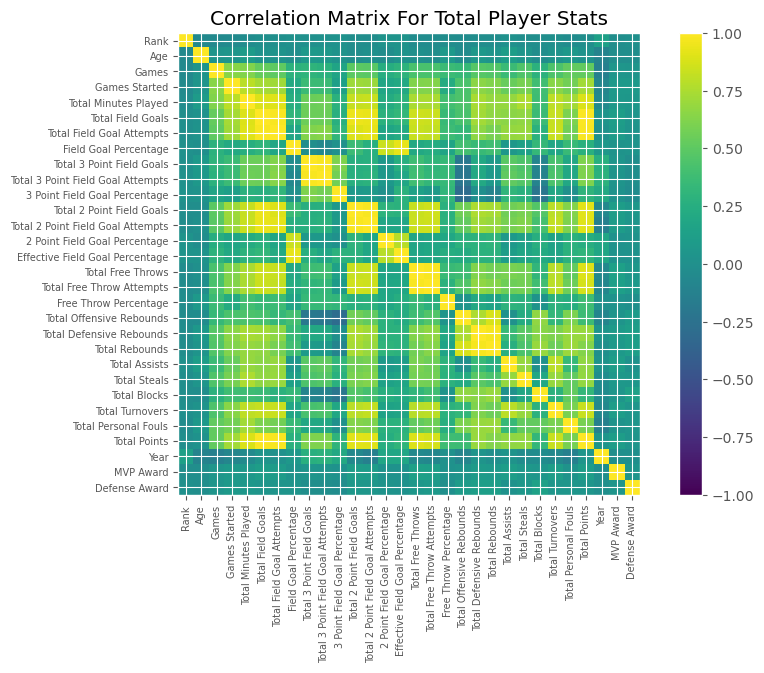

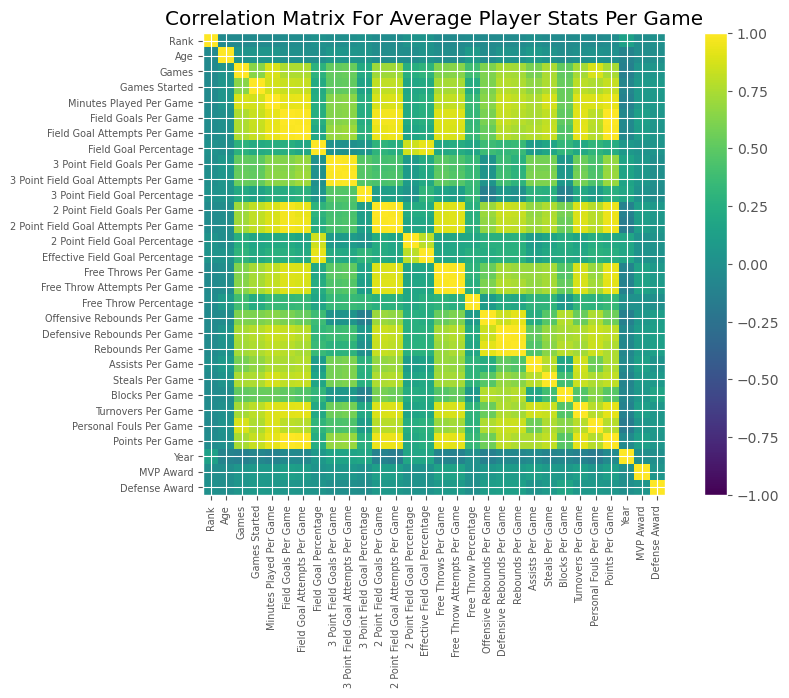

In [14]:
# create a heat map to visualize the correlation between variables for both total player stats and player stats per game
# remove non numerical data so correlation matrix can be obtained
player_stat_game_df2 = player_stat_game_df.drop(columns = ['Player', 'Position', 'Team'])
player_stat_df2 = player_stat_df.drop(columns = ['Player', 'Position', 'Team'])

# create the correlation matrices
corr_matrix_total = player_stat_game_df2.corr(method = 'pearson')
corr_matrix_game = player_stat_df2.corr(method = 'pearson')

# plot the heat map for total player stats
label = ['Rank', 'Age', 'Games', 'Games Started', 'Total Minutes Played', 'Total Field Goals', 'Total Field Goal Attempts', 'Field Goal Percentage',
        'Total 3 Point Field Goals', 'Total 3 Point Field Goal Attempts', '3 Point Field Goal Percentage', 'Total 2 Point Field Goals',
        'Total 2 Point Field Goal Attempts', '2 Point Field Goal Percentage', 'Effective Field Goal Percentage', 'Total Free Throws',
        'Total Free Throw Attempts', 'Free Throw Percentage', 'Total Offensive Rebounds', 'Total Defensive Rebounds', 'Total Rebounds',
        'Total Assists', 'Total Steals', 'Total Blocks', 'Total Turnovers', 'Total Personal Fouls', 'Total Points', 'Year', 'MVP Award', 'Defense Award']
plt.imshow(corr_matrix_total, vmin = -1, vmax = 1)
plt.colorbar()
plt.xticks(np.arange(len(label)), label, fontsize = 7, rotation = 'vertical')
plt.yticks(np.arange(len(label)), label, fontsize = 7)
plt.title('Correlation Matrix For Total Player Stats')
plt.show()

# plot the heat map for per game player stats
label2 = ['Rank', 'Age', 'Games', 'Games Started', 'Minutes Played Per Game', 'Field Goals Per Game', 'Field Goal Attempts Per Game', 'Field Goal Percentage',
        '3 Point Field Goals Per Game', '3 Point Field Goal Attempts Per Game', '3 Point Field Goal Percentage', '2 Point Field Goals Per Game',
        '2 Point Field Goal Attempts Per Game', '2 Point Field Goal Percentage', 'Effective Field Goal Percentage', 'Free Throws Per Game',
        'Free Throw Attempts Per Game', 'Free Throw Percentage', 'Offensive Rebounds Per Game', 'Defensive Rebounds Per Game', 'Rebounds Per Game',
        'Assists Per Game', 'Steals Per Game', 'Blocks Per Game', 'Turnovers Per Game', 'Personal Fouls Per Game', 'Points Per Game', 'Year', 'MVP Award', 'Defense Award']
plt.imshow(corr_matrix_game, vmin = -1, vmax = 1)
plt.colorbar()
plt.xticks(np.arange(len(label2)), label2, fontsize = 7, rotation = 'vertical')
plt.yticks(np.arange(len(label2)), label2, fontsize = 7)
plt.title('Correlation Matrix For Average Player Stats Per Game')
plt.show()

In [15]:
# create scatter plot matrix for total player stats while highlighting MVP winners
# create new dataframe so only helpful columns are included in the scatter plot matrix
# player_stat_game_df3 = player_stat_game_df[['Games', 'Minutes Played Per Game', 'Field Goal Percentage', '3 Point Field Goal Percentage',
#                                           '2 Point Field Goal Percentage', 'Free Throw Percentage', 'Total Rebounds Per Game', 'Assists Per Game',
#                                           'Steals Per Game', 'Blocks Per Game', 'Turn Overs Per Game', 'Personal Fouls Per Game', 'Points Per Game', 'MVP Award', 'Defensive Award']]
# plot the scatter matrix
# sns.pairplot(player_stat_game_df3, hue = 'MVP Award')
# sns.pairplot(player_stat_game_df3, hue = 'Defensive Award')
# plt.show()

In [16]:
# create new data frame with predictor data
player_average_game_df2 = player_average_game_df.drop(columns = ['Player', 'Position', 'Team', 'MVP Award', 'Defensive Award'])
# create data filters for splitting up testing and training data
train_years = ['0001', '0102', '0203', '0304', '0405', '0506', '0607', '0708', '0809', '0910', '1011', '1112', '1213', '1314',
              '1415', '1516', '1617', '1718', '1819', '1920', '2021']
test_year = ['2122']
# Filter both x_train and y_train based on train_years
x_train = player_average_game_df2[player_average_game_df2['Year'].isin(train_years)].to_numpy()
y_train = player_average_game_df[player_average_game_df['Year'].isin(train_years)]['MVP Award'].to_numpy()
# Filter both x_test and y_test based on train_years
x_test_first = player_average_game_df2[player_average_game_df2['Year'].isin(test_year)].to_numpy()
y_test_first = player_average_game_df[player_average_game_df['Year'].isin(test_year)]['MVP Award'].to_numpy()

# initialize old confusion matrix and model accuracy
confusion_matrix_old = [[0, 100],[0, 0]]
model_accuracy = []

# for loop used to determine the optimal class weights
for i in range(500, 5000, 100):
    for j in range(10, 100, 10):
        # Define class weights
        class_weights = {0: 1, 1: i}
        # create svm model
        svm_model = svm.SVC(kernel = 'rbf', C = j, gamma = 'scale', class_weight = class_weights)
        # train the nearest neighbor model with the training data 
        svm_model.fit(x_train, y_train)
        # get model predictions
        y_prediction = svm_model.predict(x_test_first)
        # determine the confusion matrix with the confusion_matrix function
        confusion_matrix = metrics.confusion_matrix(y_test_first, y_prediction)
        # determine ideal parameters
        if confusion_matrix[1][1] == 1 and confusion_matrix[0][1] < confusion_matrix_old[0][1]:
            best_weight = i
            best_c = j
            confusion_matrix_old = confusion_matrix

In [23]:
# display results from previous cell
print('Best Weight: ')
print(best_weight)
print('Best C Value: ')
print(best_c)

# develop svm model using the ideal parameters
ideal_class_weights = {0:1, 1:best_weight}

# develop the ideal svm model
svm_model_first = svm.SVC(kernel = 'rbf', C = best_c, gamma = 'scale', class_weight = ideal_class_weights)
# train the nearest neighbor model with the training data 
svm_model_first.fit(x_train, y_train)
# get model predictions
y_prediction = svm_model_first.predict(x_test_first)
# assess accuracy using the accuracy_score function
model_accuracy = metrics.accuracy_score(y_test_first, y_prediction)
# determine the confusion matrix with the confusion_matrix function
confusion_matrix = metrics.confusion_matrix(y_test_first, y_prediction)
print('Model Accuracy: ')
print(model_accuracy)
print('Confusion Matrix: ')
print(confusion_matrix)

# create placeholder data frame that will be used later
x_test1 = player_average_game_df2[player_average_game_df2['Year'].isin(test_year)]

# Create a DataFrame to store the predictions and corresponding players
predictions_df = player_average_game_df.loc[x_test1.index].copy()
predictions_df['First Prediction'] = y_prediction

# Filter the DataFrame to get the rows where the model predicted MVPs
predicted_mvp_df = predictions_df[predictions_df['First Prediction'] == 1]

# Print or display the predicted MVP players
display(predicted_mvp_df)

Best Weight: 
700
Best C Value: 
50
Model Accuracy: 
0.9729064039408867
Confusion Matrix: 
[[789  22]
 [  0   1]]


,Rank,Player,Position,Age,Team,Games,Games Started,Minutes Played Per Game,Field Goals Per Game,Field Goal Attempts Per Game,Field Goal Percentage,3 Point Field Goals Per Game,3 Point Field Goal Attempts Per Game,3 Point Field Goal Percentage,2 Point Field Goals Per Game,2 Point Field Goal Attempts Per Game,2 Point Field Goal Percentage,Effective Field Goal Percentage,Free Throws Per Game,Free Throw Attempts Per Game,Free Throw Percentage,Offensive Rebounds Per Game,Defensive Rebounds Per Game,Total Rebounds Per Game,Assists Per Game,Steals Per Game,Blocks Per Game,Turn Overs Per Game,Personal Fouls Per Game,Points Per Game,Year,MVP Award,Defensive Award,First Prediction
12614,141,Luka Dončić,PG,22,DAL,1.770844,3.898656,1.938183,3.449685,3.382224,1.074263,3.557880,3.436706,1.280575,3.40,3.343391,1.084993,1.084514,4.649964,4.761532,1.129146,1.107273,3.294037,2.731480,4.811278,2.059172,1.697561,4.597961,1.406171,3.635343,2122,0,0,1
12634,154,Kevin Durant,PF,33,BRK,1.498406,3.298862,2.036734,3.658756,3.178664,1.212335,2.410177,2.147942,1.387978,4.20,3.865796,1.159165,1.164044,5.646385,4.698045,1.389634,0.615152,2.738416,2.221204,3.539331,1.544379,2.546341,3.576192,1.342254,3.827351,2122,0,0,1
12636,156,Anthony Edwards,SG,20,MIN,1.961550,4.318511,1.877957,2.648243,2.708911,1.029667,3.443110,3.280492,1.298278,2.30,2.324702,1.055591,1.076165,2.574087,2.475997,1.202044,1.107273,1.547801,1.440781,2.101478,2.573964,1.697561,2.656600,1.470088,2.726507,2122,0,0,1
12642,162,Joel Embiid,C,27,PHI,1.852575,4.078594,1.850581,3.414839,3.069055,1.171924,1.606784,1.444979,1.375473,4.20,4.153119,1.078972,1.096016,7.971367,7.491478,1.230304,2.583636,3.809971,3.511903,2.322686,1.887574,4.243902,3.167485,1.725756,3.916954,2122,1,0,1
12666,175,De'Aaron Fox,PG,24,SAC,1.607381,3.538780,1.932708,3.031541,2.896812,1.102242,1.492014,1.640246,1.125175,3.75,3.735195,1.071157,1.034007,3.653543,3.745739,1.127779,0.492121,1.389052,1.170634,3.096915,2.059172,1.131707,2.860954,1.853589,2.969717,2122,0,0,1
12682,184,Darius Garland,PG,22,CLE,1.852575,4.078594,1.954608,2.787624,2.708911,1.083860,2.984028,2.616583,1.410667,2.70,2.768746,1.040437,1.099817,2.657122,2.222048,1.382627,0.738182,1.071554,0.990537,4.755976,2.230769,0.282927,3.678369,1.086587,2.777709,2122,0,0,1
12687,189,Paul George,PF,31,LAC,0.844556,1.859359,1.899857,2.996696,3.209981,0.983273,3.328339,3.241439,1.270123,2.85,3.186670,0.954208,1.002988,3.404438,3.047381,1.291712,0.492121,2.579668,2.071122,3.152217,3.775148,1.131707,4.189254,1.534005,3.110523,2122,0,0,1
12689,191,Josh Giddey,SF,19,OKC,1.471163,3.238883,1.724654,1.811956,1.941647,0.982904,1.147703,1.523086,0.932097,2.10,2.220221,1.009156,0.940452,0.830351,0.952306,1.008166,2.214545,2.381232,2.341269,3.539331,1.544379,1.131707,3.269662,1.022670,1.600063,2122,0,0,1
12690,192,Shai Gilgeous-Alexander,PG,23,OKC,1.525650,3.358842,1.899857,2.961850,2.943788,1.059718,1.836325,2.069835,1.097413,3.45,3.526233,1.043862,1.012066,4.899069,4.571071,1.239204,0.861212,1.706549,1.500813,3.262821,2.230769,2.263415,2.860954,1.597922,3.136124,2122,0,0,1
12712,214,Tyrese Haliburton,SG-PG,21,TOT,2.097769,4.618407,1.916282,1.951337,1.847697,1.112334,2.410177,1.991728,1.496839,1.75,1.776177,1.051204,1.152984,1.743737,1.587177,1.270289,0.984242,1.269990,1.200651,4.534768,2.917160,1.697561,2.656600,1.022670,1.958477,2122,0,0,1


In [18]:
# this cell develops a second svm model which is used to predict the MVPs from the pool of previously predicted MVPs
# create new test and train data from the results of previous run do this in an effort to decrease number of predicted MVPs
x_test_second = predicted_mvp_df.drop(columns = ['First Prediction', 'Player', 'Position', 'Team', 'MVP Award', 'Defensive Award']).to_numpy()
y_test_second = predicted_mvp_df['MVP Award'].to_numpy()

# initialize old confusion matrix and model accuracy
confusion_matrix_old = [[0, 100],[0, 0]]
model_accuracy = []

# for loop used to determine the optimal class weights
for i in range(10, 100, 10):
    for j in range(10, 100, 10):
        # Define class weights
        class_weights = {0: 1, 1: i}
        # create svm model
        svm_model = svm.SVC(kernel = 'rbf', C = j, gamma = 'scale', class_weight = class_weights)
        # train the nearest neighbor model with the training data 
        svm_model.fit(x_train, y_train)
        # get model predictions
        y_prediction = svm_model.predict(x_test_second)
        # determine the confusion matrix with the confusion_matrix function
        confusion_matrix = metrics.confusion_matrix(y_test_second, y_prediction)
        # determine ideal parameters
        if confusion_matrix[1][1] == 1 and confusion_matrix[0][1] < confusion_matrix_old[0][1]:
            best_weight2 = i
            best_c2 = j
            confusion_matrix_old = confusion_matrix

In [35]:
# display results from previous cell
print('Best Weight: ')
print(best_weight2)
print('Best C Value: ')
print(best_c2)

# develop svm model using the ideal parameters
ideal_class_weights = {0:1, 1:best_weight2}

# develop the ideal svm model
svm_model_second = svm.SVC(kernel = 'rbf', C = best_c2, gamma = 'scale', class_weight = ideal_class_weights)
# train the nearest neighbor model with the training data 
svm_model_second.fit(x_train, y_train)
# get model predictions
y_prediction = svm_model_second.predict(x_test_second)
# assess accuracy using the accuracy_score function
model_accuracy = metrics.accuracy_score(y_test_second, y_prediction)
# determine the confusion matrix with the confusion_matrix function
confusion_matrix = metrics.confusion_matrix(y_test_second, y_prediction)
print('Model Accuracy: ')
print(model_accuracy)
print('Confusion Matrix: ')
print(confusion_matrix)

# add final predicted winners to dataframe
predicted_mvp_df.loc[:, 'Second Prediction'] = y_prediction
display(predicted_mvp_df)

Best Weight: 
60
Best C Value: 
50
Model Accuracy: 
1.0
Confusion Matrix: 
[[22  0]
 [ 0  1]]


,Rank,Player,Position,Age,Team,Games,Games Started,Minutes Played Per Game,Field Goals Per Game,Field Goal Attempts Per Game,Field Goal Percentage,3 Point Field Goals Per Game,3 Point Field Goal Attempts Per Game,3 Point Field Goal Percentage,2 Point Field Goals Per Game,2 Point Field Goal Attempts Per Game,2 Point Field Goal Percentage,Effective Field Goal Percentage,Free Throws Per Game,Free Throw Attempts Per Game,Free Throw Percentage,Offensive Rebounds Per Game,Defensive Rebounds Per Game,Total Rebounds Per Game,Assists Per Game,Steals Per Game,Blocks Per Game,Turn Overs Per Game,Personal Fouls Per Game,Points Per Game,Year,MVP Award,Defensive Award,First Prediction,Second Prediction
12614,141,Luka Dončić,PG,22,DAL,1.770844,3.898656,1.938183,3.449685,3.382224,1.074263,3.557880,3.436706,1.280575,3.40,3.343391,1.084993,1.084514,4.649964,4.761532,1.129146,1.107273,3.294037,2.731480,4.811278,2.059172,1.697561,4.597961,1.406171,3.635343,2122,0,0,1,0
12634,154,Kevin Durant,PF,33,BRK,1.498406,3.298862,2.036734,3.658756,3.178664,1.212335,2.410177,2.147942,1.387978,4.20,3.865796,1.159165,1.164044,5.646385,4.698045,1.389634,0.615152,2.738416,2.221204,3.539331,1.544379,2.546341,3.576192,1.342254,3.827351,2122,0,0,1,0
12636,156,Anthony Edwards,SG,20,MIN,1.961550,4.318511,1.877957,2.648243,2.708911,1.029667,3.443110,3.280492,1.298278,2.30,2.324702,1.055591,1.076165,2.574087,2.475997,1.202044,1.107273,1.547801,1.440781,2.101478,2.573964,1.697561,2.656600,1.470088,2.726507,2122,0,0,1,0
12642,162,Joel Embiid,C,27,PHI,1.852575,4.078594,1.850581,3.414839,3.069055,1.171924,1.606784,1.444979,1.375473,4.20,4.153119,1.078972,1.096016,7.971367,7.491478,1.230304,2.583636,3.809971,3.511903,2.322686,1.887574,4.243902,3.167485,1.725756,3.916954,2122,1,0,1,1
12666,175,De'Aaron Fox,PG,24,SAC,1.607381,3.538780,1.932708,3.031541,2.896812,1.102242,1.492014,1.640246,1.125175,3.75,3.735195,1.071157,1.034007,3.653543,3.745739,1.127779,0.492121,1.389052,1.170634,3.096915,2.059172,1.131707,2.860954,1.853589,2.969717,2122,0,0,1,0
12682,184,Darius Garland,PG,22,CLE,1.852575,4.078594,1.954608,2.787624,2.708911,1.083860,2.984028,2.616583,1.410667,2.70,2.768746,1.040437,1.099817,2.657122,2.222048,1.382627,0.738182,1.071554,0.990537,4.755976,2.230769,0.282927,3.678369,1.086587,2.777709,2122,0,0,1,0
12687,189,Paul George,PF,31,LAC,0.844556,1.859359,1.899857,2.996696,3.209981,0.983273,3.328339,3.241439,1.270123,2.85,3.186670,0.954208,1.002988,3.404438,3.047381,1.291712,0.492121,2.579668,2.071122,3.152217,3.775148,1.131707,4.189254,1.534005,3.110523,2122,0,0,1,0
12689,191,Josh Giddey,SF,19,OKC,1.471163,3.238883,1.724654,1.811956,1.941647,0.982904,1.147703,1.523086,0.932097,2.10,2.220221,1.009156,0.940452,0.830351,0.952306,1.008166,2.214545,2.381232,2.341269,3.539331,1.544379,1.131707,3.269662,1.022670,1.600063,2122,0,0,1,0
12690,192,Shai Gilgeous-Alexander,PG,23,OKC,1.525650,3.358842,1.899857,2.961850,2.943788,1.059718,1.836325,2.069835,1.097413,3.45,3.526233,1.043862,1.012066,4.899069,4.571071,1.239204,0.861212,1.706549,1.500813,3.262821,2.230769,2.263415,2.860954,1.597922,3.136124,2122,0,0,1,0
12712,214,Tyrese Haliburton,SG-PG,21,TOT,2.097769,4.618407,1.916282,1.951337,1.847697,1.112334,2.410177,1.991728,1.496839,1.75,1.776177,1.051204,1.152984,1.743737,1.587177,1.270289,0.984242,1.269990,1.200651,4.534768,2.917160,1.697561,2.656600,1.022670,1.958477,2122,0,0,1,0


In [39]:
years = ['0001', '0102', '0203', '0304', '0405', '0506', '0607', '0708', '0809', '0910', '1011', '1112', '1213', '1314','1415',
         '1516', '1617', '1718', '1819', '1920', '2021', '2122']

complete_predicted_mvp_df = pd.DataFrame()
complete_predicted_mvp_df = complete_predicted_mvp_df.reindex(columns = predicted_mvp_df.columns)

for year in years:
    # test model to see how it predicts the winner of each year
    x_test_final_first = player_average_game_df2[player_average_game_df2['Year'].isin([year])].to_numpy()
    y_test_final_first = player_average_game_df[player_average_game_df['Year'].isin([year])]['MVP Award'].to_numpy()
    
    # get the prediction from the first model
    y_prediction_first = svm_model_first.predict(x_test_final_first)
    
    # create placeholder data frame that will be used later
    x_test1 = player_average_game_df2[player_average_game_df2['Year'].isin([year])]
    
    # Create a DataFrame to store the predictions and corresponding players
    predictions_df = player_average_game_df.loc[x_test1.index].copy()
    predictions_df['First Prediction'] = y_prediction_first
    
    # Filter the DataFrame to get the rows where the model predicted MVPs
    predicted_mvp_df = predictions_df[predictions_df['First Prediction'] == 1]
    
    # create the second set of test data based on results from the first model
    x_test_final_second = predicted_mvp_df.drop(columns = ['First Prediction', 'Player', 'Position', 'Team', 'MVP Award', 'Defensive Award']).to_numpy()
    y_test_final_second = predicted_mvp_df['MVP Award'].to_numpy()
    
    # get the prediction from the second model
    y_prediction_second = svm_model_second.predict(x_test_final_second)
    
    # add final predicted winners to dataframe
    predicted_mvp_df.loc[:, 'Second Prediction'] = y_prediction_second
    
    # fill out data frame with all the predicted winners
    complete_predicted_mvp_df = pd.concat([complete_predicted_mvp_df, predicted_mvp_df], ignore_index = True)
    
display(complete_predicted_mvp_df)

C:\Users\layto\AppData\Local\Temp\ipykernel_7160\326357885.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_mvp_df.loc[:, 'Second Prediction'] = y_prediction_second
C:\Users\layto\AppData\Local\Temp\ipykernel_7160\326357885.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_mvp_df.loc[:, 'Second Prediction'] = y_prediction_second
C:\Users\layto\AppData\Local\Temp\ipykernel_7160\326357885.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

C:\Users\layto\AppData\Local\Temp\ipykernel_7160\326357885.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_mvp_df.loc[:, 'Second Prediction'] = y_prediction_second
C:\Users\layto\AppData\Local\Temp\ipykernel_7160\326357885.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_mvp_df.loc[:, 'Second Prediction'] = y_prediction_second


,Rank,Player,Position,Age,Team,Games,Games Started,Minutes Played Per Game,Field Goals Per Game,Field Goal Attempts Per Game,Field Goal Percentage,3 Point Field Goals Per Game,3 Point Field Goal Attempts Per Game,3 Point Field Goal Percentage,2 Point Field Goals Per Game,2 Point Field Goal Attempts Per Game,2 Point Field Goal Percentage,Effective Field Goal Percentage,Free Throws Per Game,Free Throw Attempts Per Game,Free Throw Percentage,Offensive Rebounds Per Game,Defensive Rebounds Per Game,Total Rebounds Per Game,Assists Per Game,Steals Per Game,Blocks Per Game,Turn Overs Per Game,Personal Fouls Per Game,Points Per Game,Year,MVP Award,Defensive Award,First Prediction,Second Prediction
0,3.0,Shareef Abdur-Rahim,SF,24.0,VAN,1.648800,3.420382,2.000727,2.669517,2.450851,1.136315,0.278383,0.769203,0.651046,2.979932,2.776916,1.128877,1.081234,3.812444,3.372538,1.235670,2.176091,2.758151,2.590215,1.759353,1.701325,2.387728,2.406211,1.494100,2.762276,0001,0.0,0.0,1.0,0.0
1,6.0,Ray Allen,SG,25.0,MIL,1.669156,3.462609,1.910694,2.740704,2.481874,1.152035,6.959565,5.480573,2.284370,2.122691,1.906816,1.171065,1.265706,2.911321,2.452755,1.297453,1.186959,1.598928,1.480123,2.610653,2.319988,0.477546,2.074320,1.184976,2.964394,0001,0.0,0.0,1.0,0.0
2,14.0,Darrell Armstrong,PG,32.0,ORL,1.526667,3.167021,1.845670,1.957646,2.078570,0.982545,5.289269,5.192122,1.832573,1.469555,1.481022,1.043825,1.089142,2.010197,1.686269,1.303070,1.285872,1.319116,1.309340,3.972733,2.783986,0.477546,2.240266,1.081934,2.142448,0001,0.0,0.0,1.0,0.0
3,31.0,Mike Bibby,PG,22.0,VAN,1.669156,3.462609,1.945707,2.277988,2.187152,1.086565,3.618974,3.365264,1.934535,2.081870,1.962354,1.116039,1.131357,1.178392,1.175278,1.095986,0.593479,1.239169,1.053164,4.767280,2.010657,0.238773,2.489184,0.927372,2.142448,0001,0.0,0.0,1.0,0.0
4,45.0,Elton Brand,PF,21.0,CHI,1.506311,3.124794,1.965714,2.776297,2.543921,1.138533,0.000000,0.000000,0.000000,3.184036,3.036095,1.103229,1.076169,3.119272,3.270340,1.042597,3.857617,2.478339,2.874854,1.816107,1.546659,3.820365,2.489184,1.700182,2.708378,0001,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,290.0,Nikola Jokić,C,26.0,DEN,2.016038,4.438469,1.834156,3.589066,2.771545,1.363934,1.492014,1.523086,1.211727,4.500000,3.604594,1.331960,1.265682,4.234789,3.999687,1.224201,3.444848,4.365591,4.142245,4.368862,2.573964,2.546341,3.882723,1.661839,3.468937,2122,0.0,0.0,1.0,0.0
842,324.0,Zach LaVine,SG,26.0,CHI,1.825331,4.018614,1.899857,2.927005,2.771545,1.112334,3.213569,2.772797,1.433592,2.850000,2.768746,1.098239,1.132756,3.985684,3.555278,1.296213,0.369091,1.706549,1.380748,2.488592,1.029586,0.848780,2.656600,1.150504,3.123323,2122,0.0,0.0,1.0,0.0
843,383.0,Donovan Mitchell,SG,25.0,UTA,1.825331,4.018614,1.850581,3.205767,3.209981,1.051873,4.016961,3.827241,1.298278,2.850000,2.820986,1.077901,1.092808,3.321403,2.983894,1.287020,0.984242,1.349365,1.260683,2.931009,2.573964,0.565854,3.065308,1.534005,3.315331,2122,0.0,0.0,1.0,0.0
844,390.0,Ja Morant,PG,22.0,MEM,1.552894,3.418821,1.812256,3.554220,3.225640,1.160546,1.721555,1.757407,1.211727,4.300000,4.231479,1.084205,1.087503,4.566929,4.634558,1.139365,1.722424,1.746237,1.710927,3.705237,2.059172,1.131707,3.474015,0.958753,3.507338,2122,0.0,0.0,1.0,0.0


In [43]:
# determine how well the two models are able to predict the winner of the MVP award
predicted_mvp_winners = complete_predicted_mvp_df[complete_predicted_mvp_df['Second Prediction'] == 1]
display(predicted_mvp_winners)
num_true_winners = len(years)
pred_true_winners = predicted_mvp_winners['MVP Award'].sum()
percent_picked_true_winners = (pred_true_winners/num_true_winners)*100
print('Percentage that model predicts the true winner: ')
print(percent_picked_true_winners)

,Rank,Player,Position,Age,Team,Games,Games Started,Minutes Played Per Game,Field Goals Per Game,Field Goal Attempts Per Game,Field Goal Percentage,3 Point Field Goals Per Game,3 Point Field Goal Attempts Per Game,3 Point Field Goal Percentage,2 Point Field Goals Per Game,2 Point Field Goal Attempts Per Game,2 Point Field Goal Percentage,Effective Field Goal Percentage,Free Throws Per Game,Free Throw Attempts Per Game,Free Throw Percentage,Offensive Rebounds Per Game,Defensive Rebounds Per Game,Total Rebounds Per Game,Assists Per Game,Steals Per Game,Blocks Per Game,Turn Overs Per Game,Personal Fouls Per Game,Points Per Game,Year,MVP Award,Defensive Award,First Prediction,Second Prediction
47,121.0,Tim Duncan,PF,25.0,SAS,1.608979,3.259401,1.978558,3.108081,2.674969,1.202004,0.000000,0.081407,0.000000,3.620367,3.243397,1.161895,1.131768,4.625850,4.316474,1.142772,3.205128,3.748305,3.592645,2.002165,1.054217,5.781684,2.708651,1.383273,3.238424,0102,1.0,0.0,1.0,1.0
145,195.0,Allen Iverson,SG,28.0,PHI,1.022280,2.060785,2.129368,3.258953,3.607400,0.938323,3.015464,3.505042,1.525622,3.299893,3.627820,0.957983,0.940289,5.013882,4.995057,1.079942,0.703608,1.213693,1.068309,3.990370,3.725126,0.244565,3.672421,0.960153,3.570124,0304,0.0,0.0,1.0,1.0
211,205.0,Allen Iverson,PG,29.0,PHI,1.562556,3.268643,2.100173,3.559277,3.662398,0.999970,3.026608,3.403361,1.512656,3.660363,3.726356,1.022382,0.996858,5.687863,5.120030,1.190347,0.706156,1.352933,1.165977,4.543801,3.816254,0.258506,3.960848,0.957199,3.946449,0405,0.0,0.0,1.0,1.0
213,215.0,LeBron James,SF,20.0,CLE,1.666726,3.486553,2.105138,3.421053,3.193248,1.102346,3.026608,2.949580,1.745373,3.536980,3.253468,1.131512,1.101741,3.922664,3.900975,1.077469,1.412312,2.459878,2.157058,4.141186,3.498233,1.809545,2.841478,0.906821,3.496528,0405,0.0,0.0,1.0,1.0
279,197.0,Allen Iverson,PG,30.0,PHI,1.483314,3.081180,2.173103,3.992156,3.987207,1.035124,2.227057,2.412301,1.636205,4.324955,4.388245,1.029851,1.012307,6.087887,5.480362,1.202637,0.658736,1.076719,0.963062,4.581262,3.257308,0.275980,2.957207,0.875663,4.314677,0506,0.0,0.0,1.0,1.0
281,207.0,LeBron James,SF,21.0,CLE,1.627525,3.380739,2.142851,3.921498,3.640494,1.113642,3.563291,3.735176,1.690745,3.989036,3.617337,1.152292,1.118113,4.922121,4.908498,1.085628,0.988105,2.526149,2.106698,4.085991,2.742996,2.207843,2.870230,1.184721,4.105481,0506,0.0,0.0,1.0,1.0
334,199.0,Allen Iverson,PG,31.0,PHI,0.291844,0.597914,2.090099,3.383716,3.678714,0.961581,1.614392,2.488975,1.079579,3.734765,3.997035,0.990611,0.927106,6.348304,5.342855,1.261071,0.536160,0.930240,0.793213,4.052937,3.565327,0.271008,3.542518,0.722978,3.858129,0607,0.0,0.0,1.0,1.0
337,207.0,LeBron James,SF,22.0,CLE,1.517590,3.109154,2.001992,3.316712,3.135953,1.105671,2.623387,2.844542,1.535027,3.453654,3.212928,1.139608,1.092745,3.882943,4.145318,0.994165,1.179551,2.305377,1.968344,3.331181,2.592965,1.897059,2.576377,1.136109,3.375863,0607,0.0,0.0,1.0,1.0
385,203.0,Allen Iverson,SG,32.0,DEN,1.739146,3.638601,2.165388,3.071925,3.003055,1.059498,2.449400,2.431490,1.687886,3.206049,3.166405,1.062821,1.048906,5.644890,5.099399,1.204508,0.653726,0.979625,0.891119,4.203483,3.453279,0.253299,2.729775,0.733036,3.495794,0708,0.0,0.0,1.0,1.0
387,211.0,LeBron James,SF,23.0,CLE,1.590682,3.283615,2.092863,3.742805,3.461416,1.119944,3.061750,3.432692,1.494483,3.890006,3.470867,1.176437,1.110603,5.216164,5.414826,1.048190,1.961179,2.489881,2.346613,4.262687,3.107951,2.786292,3.093745,1.240523,3.972493,0708,1.0,0.0,1.0,1.0


Percentage that model predicts the true winner: 
50.0
